# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie

Klasa Vector2d reprezentująca punkty,oraz funkcje pomocniczne przydatne w dalszej częśći programu

In [3]:
#klasa ta wykorzystwana jest do reprezentowania punktów
class Vector2d:
    def __init__(self,x,y):
        self.x =x
        self.y =y
    #zwraca krotkę zawierającą współżędne wektora
    def toTuple(self):
        return (self.x,self.y)
    #pozwala na wypisanie punktu funkcją print
    def __str__(self):
            return str((self.x, self.y))
    #dodawanie  (na zasadze dodawania wektorów)
    def __add__ (self,other):
        return Vector2d(self.x+other.x,self.y+other.y)
    #odejmowanie (przydatne do obliczania odległości między punktami)
    def __sub__ (self,other):
        return Vector2d(self.x-other.x,self.y-other.y)
    #metoda umożliwia pomnożenie punktu przez skalar
    #jedneocześnie obsługuje iloczyn skalarny
    def __mul__(self,other):
        if isinstance(other, (int, float, complex)) and not isinstance(other, bool):
            return Vector2d(self.x*other,self.y*other)
        if isinstance(other,Vector2d):
            return self.x*other.y-self.y*other.x
    #zwraca długość wektora pomiędzy punktem (0,0) a naszym punktem
    def length(self):
        return np.sqrt(self.x**2+self.y**2)
    #ustawia punkt który jest interpretowany jako środek układu współżędnych
    #dla obliczania kąta biegunowego
    def set_low(low ):
        Vector2d.low = low
    #ustawia precyzje dla 0, w metodach do niego porównujących w klasie
    #stosowane gółwnie do określenia współliniowości
    def set_prec(epsilon = 1e-12):
        Vector2d.prec = epsilon
    #oblicza wyznacznik słóżący do określenia wpółżędnej biegunwej
    def det(self,c):
        res = Vector2d.low.x*self.y+Vector2d.low.y*c.x+self.x*c.y-c.x*self.y-Vector2d.low.y*self.x-Vector2d.low.x*c.y
        if  -Vector2d.prec<res<Vector2d.prec :
            return 0
        else:
            return res
    #nadpisanie operatora porównania, żeby wykorzystać wbudowane funkcje sortujące    
    def __gt__(self, other):
        det = Vector2d.det(self, other)
        if det < 0:
            return True
        if det > 0:
            return False
        return (Vector2d.low-self).length() > (Vector2d.low-other).length()
#zewnętrza funkcja obliczająca wyznacznik macierzy 3x3
#słóżąca do określenia położenia punktu c względem odcinka ab
def det3x3(a,b,c,epsilon=1e-12):
        det = ((a.x*b.y*1+a.y*1*c.x+1*b.x*c.y)
                -(1*b.y*c.x+a.x*1*c.y+a.y*b.x*1))
        if -epsilon<det<epsilon:
            return 0
        else:
            return det
#funkcja konwertuje listę punktów do listy krotek
def VectorListToPoints(arr):
    return [x.toTuple() for x in arr]
#łączy punkty ze listy w pary co umożliwia póżniejsze reprezentowanie
#otoczki jako zbioru odcinków
def hull_lines(points):
    result = []
    i = 0
    while i < len(points)-1:
        result.append([points[i],points[i+1]])
        i+=1
    result.append([points[-1],points[0]])
    return result
#funkcja dodająca pojedyńczą "klatkę" do animacji
def get_frame(scenes,hull,InPoints=[],end=False):
    hull = VectorListToPoints(hull)
    if end:
        lines = hull_lines(hull)
    else:
        lines = hull_lines(hull)[:-1]
    InPoints = VectorListToPoints(InPoints)
    scenes.append(Scene([PointsCollection(InPoints,marker = '.'),PointsCollection(hull, color='red',marker="D")], 
              [LinesCollection(lines,color='red')]))   

#domyślne ustawienie precyzj dla klasy
Vector2d.set_prec(1e-10)

### Generowanie Zbiorów punktów

Zbiór A

Zbiór A pkt 1

In [15]:
A = [Vector2d(x,y) for (x,y) in zip([random.uniform(-100,100) for _ in range(100)],[random.uniform(-100,100) for _ in range(100)])]
Ap = VectorListToPoints(A)

<IPython.core.display.Javascript object>


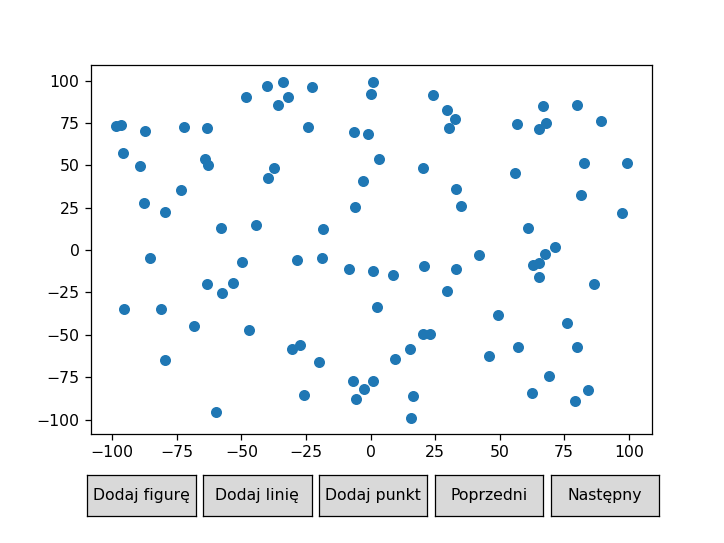

In [16]:
%matplotlib notebook
plot=Plot(points=[PointsCollection(Ap)])
plot.draw()

Uogulniona funkcja generująca zbiory "klasy A"

In [17]:
def generuj_losowe_punkty(n,down,up):
    return [Vector2d(x,y) for (x,y) in zip([random.uniform(down,up) for _ in range(int(n))],[random.uniform(down,up) for _ in range(int(n))])]


Zbiór B pkt 1

In [18]:
B=[Vector2d(10*np.sin(x),10*np.cos(x)) for x in [random.uniform(-100,100) for _ in range(100)]]
Bp = VectorListToPoints(B)

<IPython.core.display.Javascript object>


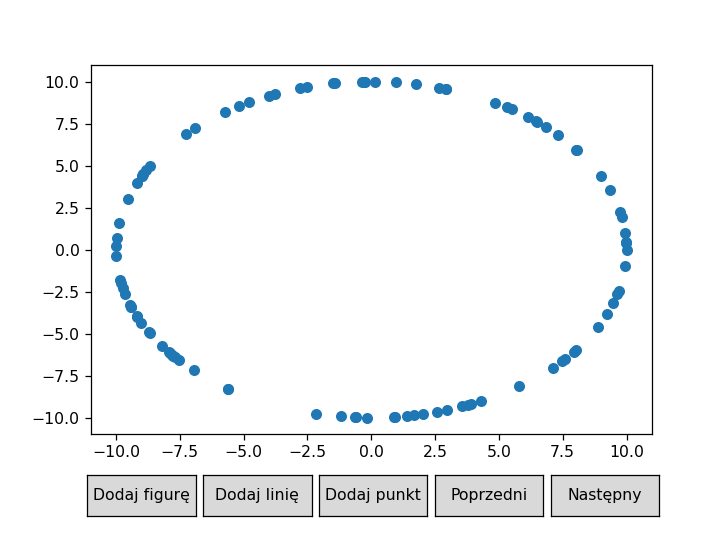

In [19]:
%matplotlib notebook
plot=Plot(points=[PointsCollection(Bp)])
plot.draw()

Uogulniona funkcja generująca zbiory "klasy B" <br>
Jako wartości domyślne przyjmuje parametry podane w zadaniu

In [20]:
def generowanie_okregu(centre=Vector2d(0,0),R=10,n=100):
    return [Vector2d(R*np.sin(x),R*np.cos(x))+centre for x in [random.uniform(-100,100) for _ in range(int(n))]]

Uogulniona funkcja generująca zbiory "klasy C" <br>
Jako wartości domyślne przyjmuje parametry podane w zadaniu

In [21]:
def generowanie_prostokat(a=Vector2d(0,0),b=Vector2d(10,0),c=Vector2d(10,10),d=Vector2d(0,10),n=100):
    v1 = b-a
    v2 = c-b
    zbior = []
    for _ in range(int(n)):
        bok = random.randint(1,4)
        skalar = random.uniform(0,1)
        if bok == 1:
            punkt = Vector2d(a.x+skalar*v1.x,a.y)
            zbior.append(punkt)
        if bok == 2:
            punkt = Vector2d(d.x+skalar*v1.x,d.y)
            zbior.append(punkt)
        if bok == 3:
            punkt = Vector2d(a.x,a.y+skalar*v2.y)
            zbior.append(punkt)
        if bok == 4:
            punkt = Vector2d(b.x,b.y+skalar*v2.y)
            zbior.append(punkt)
    return zbior


Generowanie zbioru klasy C o parametrach podanych w poleceniu

<IPython.core.display.Javascript object>


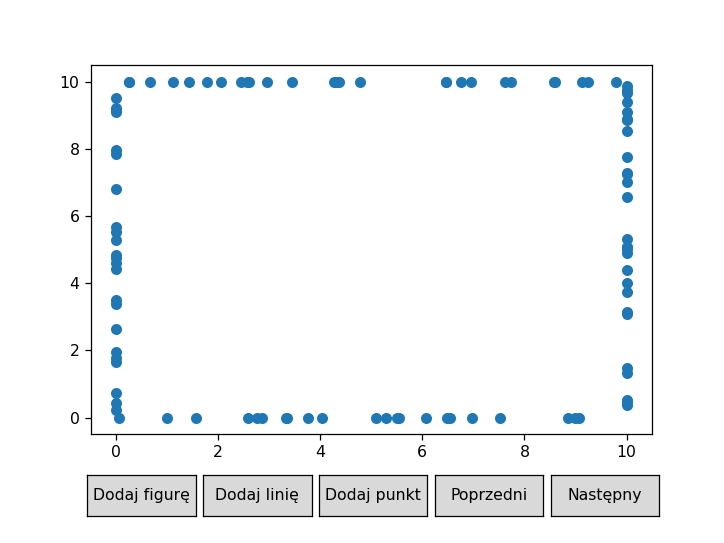

In [22]:
C = generowanie_prostokat()
punktyP =VectorListToPoints(C)
%matplotlib notebook
plot=Plot(points=[PointsCollection(punktyP)])
plot.draw()

Uogulniona funkcja generująca zbiory "klasy D" <br>
Jako wartości domyślne przyjmuje parametry podane w zadaniu

In [4]:
def generowanie_kwadratu(a=Vector2d(0,0),b=Vector2d(10,0),c=Vector2d(10,10),d=Vector2d(0,10),n1=25,n2=25):
    zbior = [a,b,c,d]
    bok = (a-b).length()
    przekatna1 = c-a
    przekatna2 = b-d
    for _ in range(int(n1)):
        skalar = random.uniform(0,1);
        if random.randint(0,1):
            zbior.append(Vector2d(0,bok*skalar))
        else:
            zbior.append(Vector2d(bok*skalar,0))
    for _ in range(int(n2)):
        skalar = random.uniform(0,1);
        if random.randint(0,1):
            zbior.append(Vector2d(a.x+skalar*przekatna1.x,a.y+skalar*przekatna1.y))
        else:
            zbior.append(Vector2d(d.x+skalar*przekatna2.x,d.y+skalar*przekatna2.y))
    return zbior

        
    


Generowanie zbioru "klasy D" o parametrach podanych w poleceniu

<IPython.core.display.Javascript object>


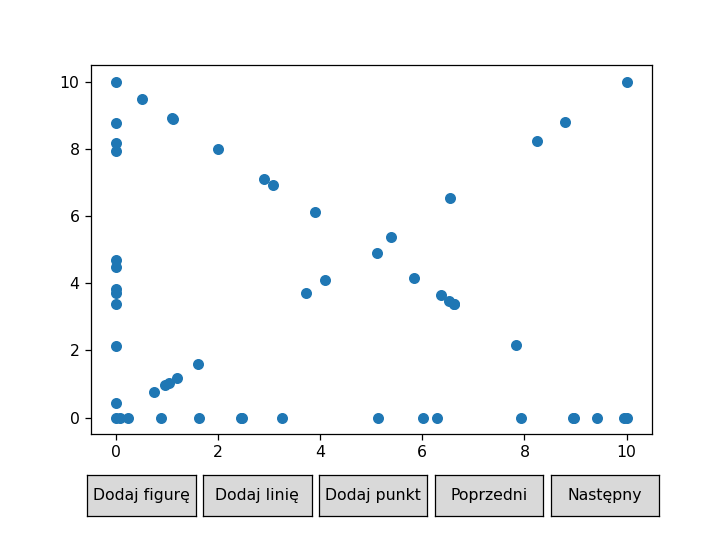

In [24]:
%matplotlib notebook
D = generowanie_kwadratu()
punktyP = VectorListToPoints(D)
plot=Plot(points=[PointsCollection(punktyP)])
plot.draw()

## Algorytm Grahama

In [11]:
def algorytmGrachama(points,epsilon=1e-12,wiz = True,old_col = True,to_file=False):
    
    #funkcja sortująca punkty po współżędnej biegunowej
    #a jeśli mają taką samą to po  odległości od punktu obranego jako 
    #środek układu współżędnych
    #wykorzystuje wcześniej nadpisane porównywanie punktów 
    def angle_sort(points, e=1e-14,first=None):
        if first == None:
            first = min(points, key = lambda x: (x.y,x.x))
        points.remove(first)
        Vector2d.set_low(first)
        Vector2d.set_prec(e)
        res = sorted(points)
        points.append(first)
        return [first]+res
    # wybór funkcji usuwającej punkty współliniowe zależy od flagi old_col
    if old_col:
         #Poprzednia wersja funkcji usuwającej punkty o tym samym kącie biegunowym
         #Omówienie dlaczego funkcja została zmieniona znajduje się w sprawozdaniu
        def delete_col(points):
            hpoints = len(points)
            i = 2
            while i < hpoints:
                if points[i].det(points[i-1]) == 0:
                    points.remove(points[i-1])
                    hpoints = len(points)
                    i-=1
                i+=1
    else:
        #funkcja usuwająca z posortowanego zbioru punktów punkty o tym samym kącie biegunowym
        def delete_col(points):
            hpoints = len(points)
            i = 2
            results = [points[0]]
            while i < hpoints-1:
                while i < hpoints-2 and points[i].det(points[i+1]) == 0 :
                    i+=1
                results.append(points[i])
                i+=1
            results.append(points[-1])
            points[:]=results
    
    
    #kopiowanie tablicy, podanej jako argument, żeby nie dokonwyać na niej modyfikacji
    points = points[:]
    #ustawienie precyzji obliczania wyznaczników
    Vector2d.set_prec(epsilon)
    # wszystkie if'y o warunku wiz odpowiadają za wizualizacje
    if wiz:
        pointsWiz = points[:]
    if wiz:
        scenes = [Scene([PointsCollection(VectorListToPoints(pointsWiz),marker = '.')])]
    # sortowanie punktów
    points = angle_sort(points)
    # redukcja punktów o punkty o tym samym kącie biegunowym
    delete_col(points)
    #inicjalizacja stosu i dodanie pierwszych wartości
    stos = []
    stos.append(points[0])
    #jeżeli zależy nam żeby usunięte punkty były niewidoczne wstarczy zamiast pointsWiz do
    #funkcj get_frame przekazywać points
    if wiz:
        get_frame(scenes,stos,pointsWiz)
    stos.append(points[1])
    if wiz:
        get_frame(scenes,stos,pointsWiz)
    stos.append(points[2])
    if wiz:
        get_frame(scenes,stos,pointsWiz)
    m = len(points)
    i = 3
    #pętla gówna
    while i < m:
        if wiz:
            get_frame(scenes,stos,pointsWiz)
        #warunek zdejmowania ze stosu
        while det3x3(stos[-2],stos[-1],points[i],epsilon) <= 0 and len(stos) >= 2:
            stos.pop()
        #dodawanie kolejnego punktu do stosu
        stos.append(points[i])
        i+=1
    if to_file:
        file = open("GrachamResults.txt","a")
        file.writelines("-_-_-_-_-_-_-_-_-_-_-_-_ \n")
        file.writelines("Wyniki\n")
        file.writelines("-_-_-_-_-_-_-_-_-_-_-_-_\n")
        for i in stos:
            file.writelines(i.__str__()+"\n")
        file.close()
    if wiz:
        get_frame(scenes,stos,pointsWiz)
        get_frame(scenes,stos,pointsWiz,True)
        return stos,scenes
    return stos

#### Wizualizacje działań algorytmu Grahama na przykładowych zbiorach

Zbiór "klasy A"

<IPython.core.display.Javascript object>


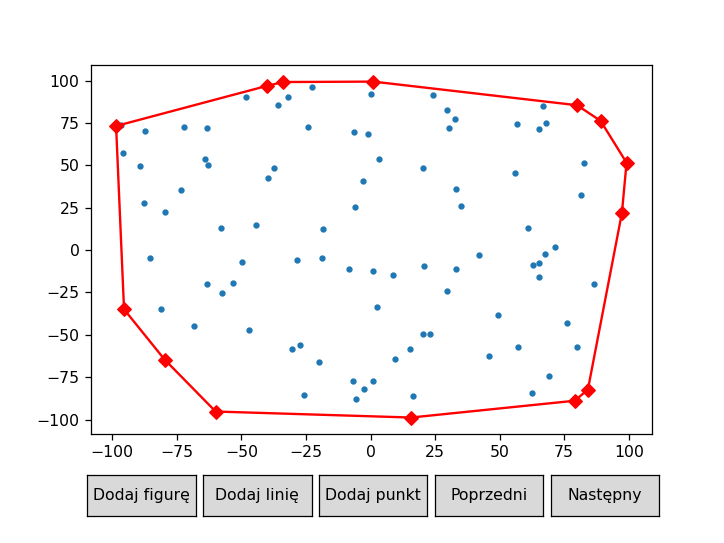

In [26]:
%matplotlib notebook
otoczka,x = algorytmGrachama(A)
otoczka = VectorListToPoints(otoczka)
linie = hull_lines(otoczka)
punkty = VectorListToPoints(A)
plot=Plot(x)
plot.draw()

Zbiór "klasy B"

<IPython.core.display.Javascript object>


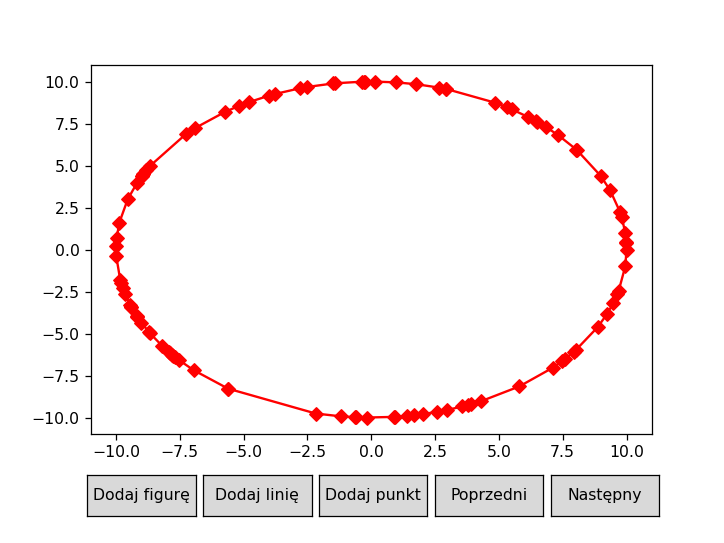

In [27]:
%matplotlib notebook
otoczka,x = algorytmGrachama(B)
otoczka = VectorListToPoints(otoczka)
plot=Plot(x)
plot.draw()

Zbiór "klasy C"

<IPython.core.display.Javascript object>


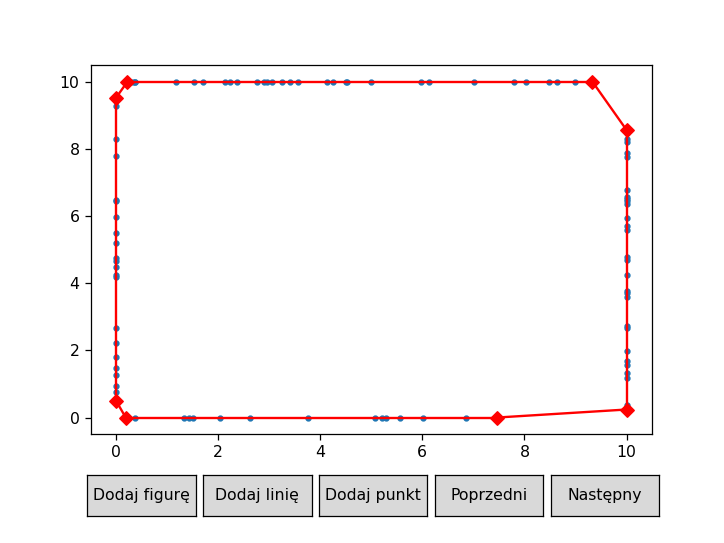

In [48]:
%matplotlib notebook
otoczka,x = algorytmGrachama(C,1e-12,True,False,True)
plot=Plot(x)
plot.draw()

Zbiór "klasy D"

<IPython.core.display.Javascript object>


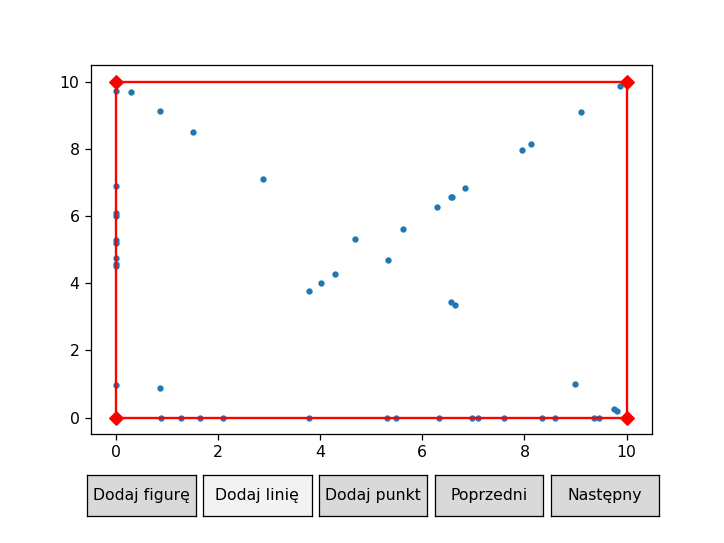

In [21]:
%matplotlib notebook
otoczka,x = algorytmGrachama(D)
plot=Plot(x)
plot.draw()


### Algorytm Jarvisa

In [6]:
def algorytmJarvisa(points,epsilon=1e-12,wiz=True,to_file=False):
    #kopiowanie tablicy punktów
    points = points[:]
    Vector2d.set_prec(epsilon)
    #funkcja pomocnicza wyszukująca kolejny punkt wedłóg współżędnej biegunowej i odległości
    def nastepny(points,prev):
        #metoda analogiczna do tej w klasie punkt nadpisującej operator porównania
        #ale z odwrotnym znakiem dla odległości
        def test(prev,actual):
            det = prev.det(actual)
            if det < 0:
                return True
            elif det > 0:
                return False
            else:
                return (Vector2d.low-prev).length() <(Vector2d.low-actual).length()
        #sytułącja kiedy przeszkuiwana tablica jest pusta
        if not points:
            return
        #wybranie punktu od którego zaczynamy szukać
        actual = points[0]
        Vector2d.set_low(prev)
        #przeszukujemy pozostałe punkty
        for i in range(1,len(points)):
            if test(actual,points[i]):
                actual = points[i]
        return actual
    #anaglogicznie jak w algorytmie grachama if'y z warunkiem wiz odpowiadają za wizualizacje
    if wiz:
        scenes = [Scene([PointsCollection(VectorListToPoints(points),marker = '.')])]
    #wyszukujemy pierwszy punkt
    first = min(points,key = lambda x : (x.y,x.x))
    results = [first]
    points.remove(first)
    if wiz:
            get_frame(scenes,results,points)
    #wybieramy drugi punkt otoczki
    actual = nastepny(points,first)
    #dopuki otoczka nie zostanie kolejna szukamy kolejnych punktów
    while actual != first and points:
        points.remove(actual)
        results.append(actual)
        actual = nastepny([first]+points,actual)
        if wiz:
            get_frame(scenes,results,points)
    if to_file:
        file = open("JarvisResults.txt","a")
        file.writelines("-_-_-_-_-_-_-_-_-_-_-_-_ \n")
        file.writelines("Wyniki\n")
        file.writelines("-_-_-_-_-_-_-_-_-_-_-_-_\n")
        for i in results:
            file.writelines(i.__str__()+"\n")
        file.close()
    if wiz:
        get_frame(scenes,results,points,True)
        return results,scenes
    else:
        return results

#### Wizualizacje działań algorytmu Jarvisa na przykładowych zbiorach

Zbiór "Klasy A"

<IPython.core.display.Javascript object>


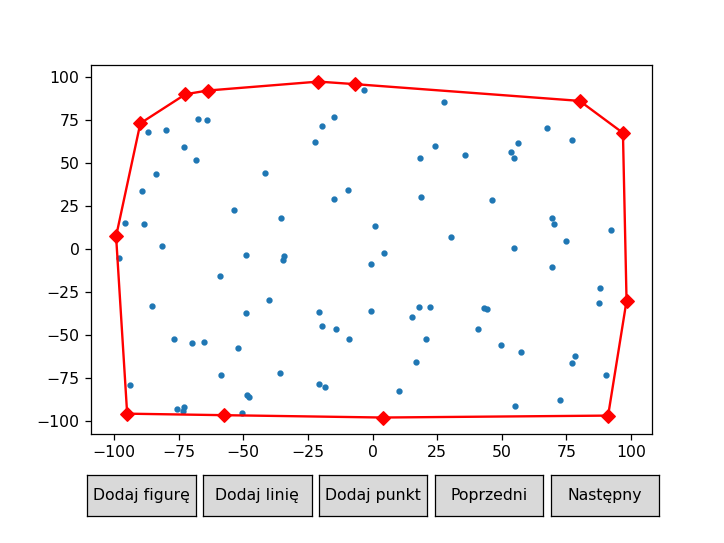

In [23]:
%matplotlib notebook
otoczka,x = algorytmJarvisa(A)
plot =Plot(x)
plot.draw()

Zbiór "Klasy B"

<IPython.core.display.Javascript object>


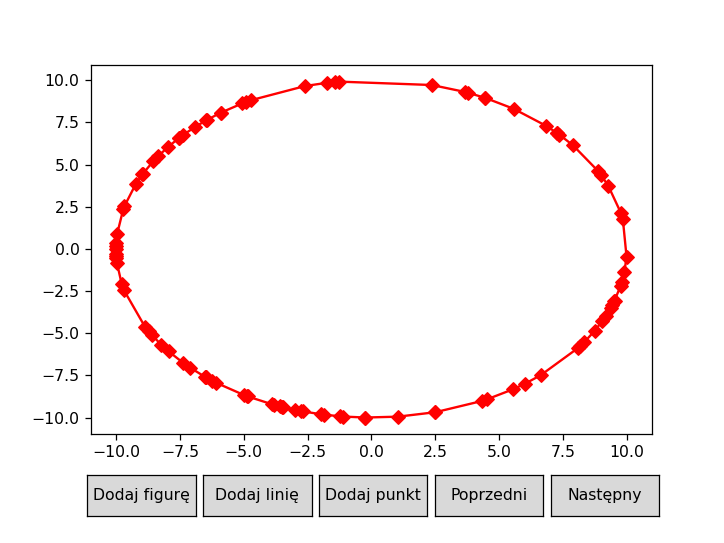

In [24]:
%matplotlib notebook
otoczka,x = algorytmJarvisa(B)
plot =Plot(x)
plot.draw()

Zbiór "Klasy C"

<IPython.core.display.Javascript object>


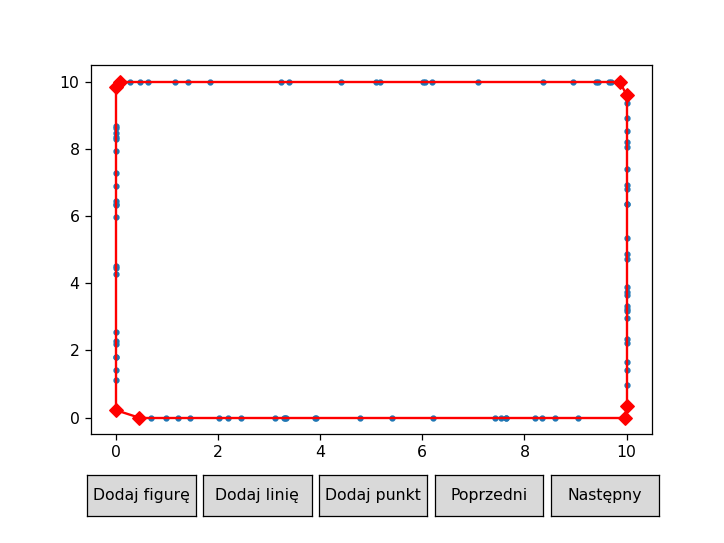

In [28]:
%matplotlib notebook
otoczka,x = algorytmJarvisa(C)
plot =Plot(x)
plot.draw()

Zbiór "Klasy D"

<IPython.core.display.Javascript object>


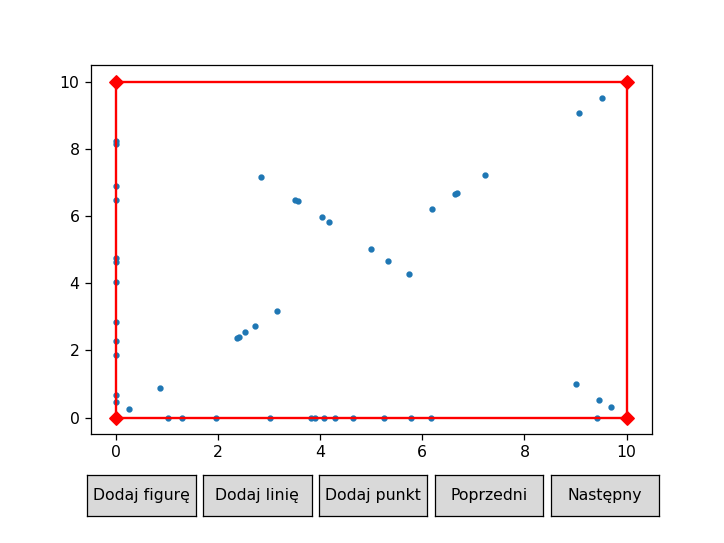

In [30]:
%matplotlib notebook
otoczka,x = algorytmJarvisa(D)
plot =Plot(x)
plot.draw()

### Testy Algorytmów 

In [5]:
#funkcja do testowania obu algorytmów
#przyjmuje jako argumenty funkcje do generacji punktów
#liste argumentów tej funkcji
#oraz oba algorytmy do przetestowania
#zwraca listę pomiarów czasowych
def time_test(points_function,args,alg1,alg2):
    import time
    results = []
    ot=0
    for i in args:
        row = []
        for par in i:
            row.append(par)
        points = points_function(*i)
        start = time.time()
        ot=alg1(points,1e-12,False)
        row.append(time.time()-start)
        start = time.time()
        ot=alg2(points,1e-12,False)
        row.append(time.time()-start)
        row[3:3]=[len(ot)]
        results.append(row)
    return results
        
    

### wyniki testów

#### Test dla zbioru n losowych punktów o współżędnych z przedziału [a,b]

In [68]:
# test przy stałym przedziale [a,b]
kolumny = ["n","a","b","Liczba punktów na otoczce","Alorytm Grahama","Algorytm Jarvisa"]
args=[]
for i in range(1000,100000,5000):
    args.append([i,-1000,1000])
#args = [[100,-1000,1000],[500,-1000,1000],[1000,-1000,1000],[5000,-1000,1000],[10000,-1000,1000],]
data = time_test(generuj_losowe_punkty,args,algorytmGrachama,algorytmJarvisa)

In [69]:
data
pd.DataFrame(data,columns=kolumny)

,n,a,b,Liczba punktów na otoczce,Alorytm Grahama,Algorytm Jarvisa
0,1000,-1000,1000,18,0.015012,0.019947
1,6000,-1000,1000,23,0.083781,0.130654
2,11000,-1000,1000,24,0.162566,0.254303
3,16000,-1000,1000,21,0.255291,0.327157
4,21000,-1000,1000,27,0.331105,0.546996
5,26000,-1000,1000,25,0.430067,0.617940
6,31000,-1000,1000,30,0.515934,0.895274
7,36000,-1000,1000,23,0.736996,1.185144
8,41000,-1000,1000,27,0.998924,1.581052
9,46000,-1000,1000,31,1.134000,1.976211


In [70]:
# test przy rosnącym przedziale [a,b]
kolumny = ["n","a","b","Liczba punktów na otoczce","Alorytm Grahama","Algorytm Jarvisa"]
args=[]
for i in range(1000,100000,5000):
    args.append([i,-i,i])
#args = [[100,-1000,1000],[500,-1000,1000],[1000,-1000,1000],[5000,-1000,1000],[10000,-1000,1000],]
data = time_test(generuj_losowe_punkty,args,algorytmGrachama,algorytmJarvisa)
data
pd.DataFrame(data,columns=kolumny)

,n,a,b,Liczba punktów na otoczce,Alorytm Grahama,Algorytm Jarvisa
0,1000,-1000,1000,19,0.012997,0.019967
1,6000,-6000,6000,25,0.082781,0.140605
2,11000,-11000,11000,25,0.160560,0.268286
3,16000,-16000,16000,21,0.250348,0.330111
4,21000,-21000,21000,29,0.342371,0.595141
5,26000,-26000,26000,28,0.424909,0.709070
6,31000,-31000,31000,26,0.532984,0.797399
7,36000,-36000,36000,27,0.608942,0.945879
8,41000,-41000,41000,29,0.705648,1.149009
9,46000,-46000,46000,24,0.793008,1.053944


#### Test dla n punktów leżących na okręgu o promieniu R o środku w punkcie (x,y)

In [71]:
kolumny = ["środek","promień","n","Liczba punktów na otoczce","Alorytm Grahama","Algorytm Jarvisa"]
args = [[Vector2d(0,0),1e1,1e2],[Vector2d(0,0),1e1,1e3],[Vector2d(0,0),1e1,1e4]]
args=[]

for i in range(100,3000,200):
    args.append([Vector2d(0,0),i/10,i])
    
data = time_test(generowanie_okregu,args,algorytmGrachama,algorytmJarvisa)
pd.DataFrame(data,columns=kolumny)

,środek,promień,n,Liczba punktów na otoczce,Alorytm Grahama,Algorytm Jarvisa
0,"(0, 0)",10.0,100,100,0.002028,0.012479
1,"(0, 0)",30.0,300,300,0.007979,0.112208
2,"(0, 0)",50.0,500,500,0.011968,0.344121
3,"(0, 0)",70.0,700,700,0.022801,0.651369
4,"(0, 0)",90.0,900,900,0.023938,1.069057
5,"(0, 0)",110.0,1100,1100,0.029971,1.615048
6,"(0, 0)",130.0,1300,1300,0.035956,2.270530
7,"(0, 0)",150.0,1500,1500,0.042885,2.998446
8,"(0, 0)",170.0,1700,1700,0.050075,3.703142
9,"(0, 0)",190.0,1900,1900,0.058869,5.085201


#### Test dla n punktów leżących na prostokącie

In [72]:
kolumny = ["n","Liczba punktów na otoczce","Alorytm Grahama","Algorytm Jarvisa"]
wierzcholki = [Vector2d(0,0),Vector2d(10,0),Vector2d(10,10),Vector2d(0,10)]
args = []
for i in range(100,100000,5000):
    args.append([*wierzcholki,i])
data = time_test(generowanie_prostokat,args,algorytmGrachama,algorytmJarvisa)
data = [x[5:6]+x[3:4]+x[6:] for x in data]
pd.DataFrame(data,columns=kolumny)

,n,Liczba punktów na otoczce,Alorytm Grahama,Algorytm Jarvisa
0,100,8,0.002027,0.000965
1,5100,8,0.123670,0.062863
2,10100,8,0.255334,0.120629
3,15100,8,0.419877,0.185679
4,20100,8,0.564056,0.248174
5,25100,8,0.720887,0.307393
6,30100,8,0.982213,0.511690
7,35100,8,1.314261,0.434531
8,40100,8,1.236364,0.492683
9,45100,8,1.734211,0.551080


#### Test dla n1 punktów leżących na bokach kwadratu i n2 leżących na jego przekątnych

In [10]:
# przed uruchomieniem tych testów warto zmienić wartość domyślną argumentu old_col algorytmu Grachama na False 
#( o ile nie jest już ustawiona)
# i upewnij się że  uruchomiłeś po tym funkcję algorytmu Grachama jeszcze raz
#bez ustawienia tej flagi ten test może trwać ~30 min
kolumny = ["n1","n2","Punkty na otoczce","Alorytm Grahama","Algorytm Jarvisa"]
wierzcholki = [Vector2d(0,0),Vector2d(10,0),Vector2d(10,10),Vector2d(0,10)]
args = []
for i in range(5000,100000,5000):
    args.append([*wierzcholki,i,i])
data = time_test(generowanie_kwadratu,args,algorytmGrachama,algorytmJarvisa)
data = [x[5:7]+x[3:4]+x[7:] for x in data]
pd.DataFrame(data,columns=kolumny)

,n1,n2,Punkty na otoczce,Alorytm Grahama,Algorytm Jarvisa
0,5000,5000,4,0.645275,0.101730
1,10000,10000,4,1.355395,0.202404
2,15000,15000,4,2.123311,0.306236
3,20000,20000,4,3.042927,0.398931
4,25000,25000,4,3.919547,0.588393
5,30000,30000,4,5.565106,0.634303
6,35000,35000,4,5.759639,0.722069
7,40000,40000,4,6.368925,0.828786
8,45000,45000,4,8.348667,1.149925
9,50000,50000,4,8.515363,1.005311


In [12]:
#dla porównania wyniki dla starej funkcji usuwającej punkty w algorytmie Grachama
kolumny = ["n1","n2","Punkty na otoczce","Alorytm Grahama","Algorytm Jarvisa"]
wierzcholki = [Vector2d(0,0),Vector2d(10,0),Vector2d(10,10),Vector2d(0,10)]
args = []
for i in range(5000,100000,5000):
    args.append([*wierzcholki,i,i])
data = time_test(generowanie_kwadratu,args,algorytmGrachama,algorytmJarvisa)
data = [x[5:7]+x[3:4]+x[7:] for x in data]
pd.DataFrame(data,columns=kolumny)

,n1,n2,Punkty na otoczce,Alorytm Grahama,Algorytm Jarvisa
0,5000,5000,4,1.937846,0.098736
1,10000,10000,4,6.204487,0.200466
2,15000,15000,4,13.064026,0.298203
3,20000,20000,4,22.349276,0.395922
4,25000,25000,4,33.721790,0.498667
5,30000,30000,4,48.144179,0.585442
6,35000,35000,4,65.076012,0.830810
7,40000,40000,4,94.831748,0.823993
8,45000,45000,4,117.211949,0.951221
9,50000,50000,4,131.621590,1.000957
